# Subgraphs

A subgraph is a graph that is used as a node in another graph. This helps with:
* Encapsulation of re-usable graphs
* Simplifies the design of complex system such as multi-agent systems
* Independent development of graphs (think microservices)

## State management
Parent & Subgraph may have different state keys. There are 2 options to deal with the state

1. **Shared schema keys** : Parent & subgraph can have *shared state keys* in their state schema
   - Add subgraph as a node
2. **Different schema** : Subgraph invoked from a node in the parent graph
   - Call the subgraph from inside a node
   - Transform the state before/after the call to subgraph

https://langchain-ai.github.io/langgraph/concepts/subgraphs/

### Note
The code is intentionally kept simple as the intent is to show the working of subgraphs. The subgraph can be complex graphs with fully blown functionality.

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import List, Annotated, TypedDict
from IPython.display import Image, display
import random
import operator

## Parent state

Define the state of the parent

In [2]:
# State schema of the parent graph
class StateParentGraph(TypedDict):
    topic: str                     # Report topic
    report: str                    # Generated content of the report
    quality: float                 # Refers to a score between 1 & 5


## Subgraphs

### Research subgraph : shares keys with parent
* Simple graph to demonstrate the working of a subgraph.
* Added as a node to the parent graph

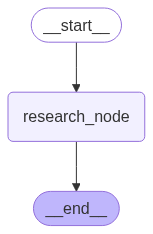

In [3]:
# State schema shares the 'report' attribute with the parent
class  StateResearchSubgraph(TypedDict):
    topic: str
    report: str  # Shared attribute
    
# Dummy processing
def research_node(state: StateResearchSubgraph) -> TypedDict:
    return { "report": f"This is a dummy report on {state["topic"]}"}

# Create the subgraph
subgraph_research = StateGraph(StateResearchSubgraph)

# Add the research node
subgraph_research.add_node("research_node", research_node)

# Add the edges
subgraph_research.add_edge(START, "research_node")
subgraph_research.add_edge("research_node", END)

subgraph_research_compiled = subgraph_research.compile()

# Unit testing
# subgraph_research_compiled.invoke({"topic": "movies"})

# Display subgraph
display(Image(subgraph_research_compiled.get_graph().draw_mermaid_png()))

### Reviewer subgraph : doesn't shares keys with parent
* A node is created in the parent graph to invoke this graph

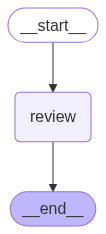

In [4]:
class  StateReviewerSubgraph(TypedDict):
    content: str
    score: int

def review_node(state: StateReviewerSubgraph) -> TypedDict:
    return { "score": 3}

subgraph_review = StateGraph(StateReviewerSubgraph)

subgraph_review.add_node("review", review_node)

subgraph_review.add_edge(START, "review")
subgraph_review.add_edge("review", END)

subgraph_review_compiled = subgraph_review.compile()

subgraph_review_compiled.invoke({"article": "another dummy text"})

# Display subgraph
display(Image(subgraph_review_compiled.get_graph().draw_mermaid_png()))

## Parent graph

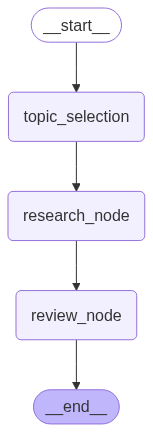

{'topic': 'movies', 'report': 'This is a dummy report on movies', 'quality': 3}

In [5]:
# Parent node
# Dummy node that picks a topic for research
def topic_node(StateParentGraph):
    # some processing
    return {"topic": "movies"}

# Parent node : invokes subgraph for review (subgraph without shared key)
# 1. Converts the state schema to match with the state schema supported by Review node
# 2 Node invokes the subgraph 
# 3. Converts the response to the state schema for the parent graph
def review_node(state:StateParentGraph):
    response = subgraph_review_compiled.invoke({"content": state["report"]})
    review_score = response["score"]
    return {"quality": review_score}


# Graph
parent_graph = StateGraph(StateParentGraph)

parent_graph.add_node("topic_selection",topic_node)
# subgraph with shared keys
parent_graph.add_node("research_node",subgraph_research_compiled)
# subgraph without shared keys
parent_graph.add_node("review_node",review_node)

# Add edges
parent_graph.add_edge(START, "topic_selection")
parent_graph.add_edge("topic_selection", "research_node")
parent_graph.add_edge("research_node","review_node")
parent_graph.add_edge("review_node", END)

# Compile
parent_graph_compiled = parent_graph.compile()

# Display
display(Image(parent_graph_compiled.get_graph().draw_mermaid_png()))

# Invoke
parent_graph_compiled.invoke({})